# Final Submission for Mod 2 Project
Created by Albert Um Data Science Cohort 06/22/20

Using Linear Regression to find variables that explain the target, Baby Weight.

The notebook contains the following:
1. Data Preprocessing
2. Visualizations with Statistical Tests
3. Model Approach
4. Key Insights


# 1. Data Preprocessing
The dataset has 3.8 million rows with 55 columns. Please use an appropriate sample size before plotting. <br>
I will first need to transform some of the integer-like categorical values. The keys are located in 'US_Birth_columns' text file. <br>
In addition, I will need to engineer new variables to better enhance the R2 score.

### Libraries to import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
%matplotlib inline

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

### Import Data:

In [2]:
df = pd.read_csv('../US_births.csv', low_memory=False)
df = df.sample(n=250_000, random_state=42)
df.shape

(250000, 55)

### Dropping Rows:
Unfortunately, we will have to drop some continuous variables that are 'Unknown' or 'Not available'. <br>
For more information about the columns and it's values, look to US_Birth_columns.

In [3]:
def drop_rows(df):
    '''
    Dropping rows where missing: 'DBWT', 'BMI', 'DBWT', 'WTGAIN', 'PWgt_R', 'DLMP_MM', 'DLMP_YY'
    '''
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)    
    df.drop(df[df['BMI'].eq(99.9)].index, inplace=True)
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
    df.drop(df[df['WTGAIN'].eq(99)].index, inplace=True)
    df.drop(df[df['PWgt_R'].eq(999)].index, inplace=True)
    df.drop(df[df['DLMP_MM'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_YY'].eq(9999)].index, inplace=True)
    
    df.drop(columns=['IMP_SEX'], inplace=True)
    return df


In [4]:
df = drop_rows(df)
df.shape

(231493, 54)

### Feature Engineering:
As well as transforming the integer-like categorical values to objects, I will create some new features that can help my r2 score.<br>
I have chosen not to drop the rows with unknown categorical values. I'll treat them as it's own class.

In [5]:
def feature_engineer(df):
    '''
    Creating new column: 'first_birth', 'smoked', 'PRIORDEAD_cat', 'PRIORTERM_cat', 'PRIORLIVE_cat', 
    
    '''

    #creating new column called 'first_birth': Is the baby the Mom's first child? Yes:1 No:0
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)
    df['plural_delivery'] = np.where(df['ILLB_R'].lt(4), 'Yes', 'No')


    
    #creating new column 'smoked': Did the mother smoke before pregnancy? Yes: Daily, No: None, Unknown: Unknown
    conditions = [df['CIG_0'].eq(0),
                  df['CIG_0'].eq(99)]
    choices = ['None',
               'Unknown']
    df['smoked'] = np.select(conditions, choices, 'Daily')

    
    #creating new column 'PRIORDEAD_cat': Did the mother previously have miscarriages? Yes: Yes, No: None, Unknown: Unknown
    conditions = [df['PRIORDEAD'].eq(0),
                  df['PRIORDEAD'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORDEAD_cat'] = np.select(conditions, choices, 'Yes')

    
    #creating new column 'PRIORTERM_cat': Did the mother previously have terminations? Yes: Yes, No:None, Unknown: Unknown
    conditions = [df['PRIORTERM'].eq(0),
                  df['PRIORTERM'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORTERM_cat'] = np.select(conditions, choices, 'Yes')

    #creating new column 'PRIORLIVE_cat': Did the mother previously birth living children: Yes: Yes, No: None, Unknown: Unknown
    conditions = [df['PRIORLIVE'].eq(0),
                  df['PRIORLIVE'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORLIVE_cat'] = np.select(conditions, choices, 'Yes')

    #creating new column 'pregnancy_length': An estimation of the gestation period by subtracting the month/year of last menses from month/year of baby born
    conditions = [(df['DOB_MM'] > df['DLMP_MM']) & (2018 == df['DLMP_YY']),
                  (df['DOB_MM'] > df['DLMP_MM']) & (2018 > df['DLMP_YY']),
                  (df['DOB_MM'] < df['DLMP_MM']) & (2018 > df['DLMP_YY'])]
    choices = [df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) + df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) - df['DLMP_MM'] + df['DOB_MM']]
    df['pregnancy_length'] = np.select(conditions,choices, 12)
    
    #creating new column 'MAGER_cat': Mother's age is < 18: Minor, Mother's age is >= 18: Adult
    df['MAGER_cat'] = np.where(df['MAGER'].lt(18),'Minor','Adult')

    #creating new column 'pregnancy_cat: Binning pregnancy_length to 5 bins: 'Early','8','9','10','Late'
    condition =[df['pregnancy_length'].eq(9),
                df['pregnancy_length'].eq(8),
                df['pregnancy_length'].eq(10),
                df['pregnancy_length'].lt(7)]
    choices = ['9',
              '8',
               '10',
               'Early']
    df['pregnancy_length_cat'] = np.select(condition,choices, 'Late')

    #creating new column 'BMI_log':np.log(BMI) to normalize BMI
    df['BMI_log'] = np.log(df['BMI'])
    
    #creating new column 'first_pregnancy': Is it mother's first live birth? Yes: 1, No: 0
    df['first_live_birth'] = np.where(df['ILP_R'].eq(888), 1, 0)
    
    #creating new column 'first_natal': Is it mother's first natality event? Yes: 1, No: 0
    df['first_natal'] = np.where(df['ILOP_R'].eq(888),1, 0)
    
    #adjusting 'PRECARE' values: if Unkonwn, impute 0
    df['PRECARE'] = np.where(df['PRECARE'].eq(99), 0, df['PRECARE'])
    
    #adjusting 'PREVIS' values: if Unkonwn, impute 0
    df['PREVIS'] = np.where(df['PREVIS'].eq(99), 0, df['PREVIS'])
    
    #creating new column 'T35AGE_older': Is mother's age older than 34? Yes: 1, No: 0
    df['T35AGE_older'] = np.where(df['MAGER'].gt(34), 1, 0)
    
    #creating new column 'MOM_weight': manually computing mom's weight incase of missing values
    df['MOM_weight'] = (df['M_Ht_In']**2)*df['BMI']/704
    
    #creating new column '...': Weight gained divided by Mom's Weight
    df['WTGAIN_div_MOM_weight'] = df['WTGAIN']/df['MOM_weight']
    
    #creating new column '...': Weight gained divided by gestation period
    df['WTGAIN_div_length'] = df['WTGAIN'] / df['pregnancy_length']
    
    #creating new column '...': calculating percentage of weight gained due to pregnancy
    df['WT_percent_gain'] = df['WTGAIN'] / df['PWgt_R']
    
    #adjusting 'MAR_IMP': Marriage imputed should be 0 if left blank
    df['MAR_IMP'] = np.where(df['MAR_IMP'].eq(' '),0,1)
    
    #adjusting 'DMAR': assigning blanks to a new variable 0 for unknowns
    df['DMAR'] = np.where(df['DMAR'].eq(' '),0,df['DMAR'])
    
    #creating new column '...': 
    df['pregnancy_length_sqrt'] =  np.sqrt(df['pregnancy_length'])
    
    #dropping rows that with gestation period greater than 12 and less than 5, treating them as outliers
    df.drop(df[df['pregnancy_length'].gt(12)].index,inplace=True)
    df.drop(df[df['pregnancy_length'].lt(5)].index,inplace=True)
    return df


In [6]:
df = feature_engineer(df)
df.reset_index(inplace=True,drop=True)
df.shape

(230879, 72)

### Handing picking:
From here, I hand picked the columns that will be used for this model and created dummy variables for the categorical columns.

In [7]:
X = df[['ATTEND','BFACIL', 'smoked', 'DOB_MM', 'DMAR','FHISPX','FEDUC', 'FRACE6', 'first_birth', 'plural_delivery', 'first_live_birth', 'first_natal','pregnancy_length_sqrt',
        'IP_GON', 'LD_INDL', 'MAGER', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN', 'pregnancy_length', 'WTGAIN_div_MOM_weight','WTGAIN_div_length',
        'NO_INFEC','NO_MMORB','NO_RISKS','PAY', 'PAY_REC','PRECARE','PREVIS', 'PRIORDEAD_cat', 'PRIORLIVE_cat', 'PRIORTERM_cat', 'PWgt_R', 'BMI_log','M_Ht_In', 'MOM_weight',
        'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX', 'WTGAIN','WT_percent_gain','MAGER_cat','pregnancy_length_cat','BMI'
]]

_X = pd.get_dummies(X, columns=['ATTEND', 'BFACIL','smoked', 'DOB_MM','DMAR','FHISPX','FEDUC','FRACE6', 'plural_delivery',
                                'IP_GON','LD_INDL', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN',
                                'NO_INFEC','NO_MMORB','NO_RISKS', 'PAY', 'PAY_REC','PRIORDEAD_cat', 'PRIORLIVE_cat','PRIORTERM_cat',
                                'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX','MAGER_cat','pregnancy_length_cat']).copy()
y = df['DBWT']
_X.shape

(230879, 168)

### Feature Engineering on Dummies:
I also want interactions between the dummy variables and the variables created from the first round of feature engineering

In [8]:
def feat_eng_dummy(_X):
    _X['MAGER_smoked_Daily'] = _X['MAGER'] * _X['smoked_Daily']
    _X['NO_RISKS_1_length'] = _X['NO_RISKS_1'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_length'] = _X['RDMETH_REC_3'] * _X['pregnancy_length']
    _X['RDMETH_REC_1_length'] = _X['RDMETH_REC_1'] * _X['pregnancy_length']
    _X['ATTEND_1_length'] = _X['pregnancy_length'] * _X['ATTEND_1']
    _X['MRAVE6_1_FRACE6_1'] = _X['MRAVE6_1'] * _X['FRACE6_1']
    _X['BFACIL_1_length'] = _X['pregnancy_length'] * _X['BFACIL_1']
    _X['BMI_log_length'] = _X['BMI_log'] * _X['pregnancy_length']
    _X['M_Ht_In_length'] = _X['DMAR_1'] * _X['pregnancy_length']
    _X['LD_INDL_N_length'] = _X['LD_INDL_N'] * _X['pregnancy_length']
    _X['MTRAN_Y_length'] = _X['MTRAN_Y'] * _X['pregnancy_length']
    _X['PRECARE_length'] = _X['PRECARE'] * _X['pregnancy_length']
    _X['PREVIS_length'] = _X['PREVIS'] * _X['pregnancy_length']
    _X['MOM_weight_length'] = _X['MOM_weight'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_pregnancy_length_cat_9'] = _X['RDMETH_REC_3'] * _X['pregnancy_length_cat_9']
    _X['RF_CESAR_Y_pregnancy_length_cat_9'] = _X['RF_CESAR_Y'] * _X['pregnancy_length_cat_9']
    
    return _X

In [9]:
_X = feat_eng_dummy(_X)
_X.shape

(230879, 184)

### Assigning column lists:
creating a list of continuous columns will help us when we want to scale only our contious variables

In [10]:

_X_columns = _X.columns
categorical_columns = []
continuous_columns = []
for i in _X_columns:
    if _X[i].max() == 1:
        categorical_columns.append(i)
    else:
        continuous_columns.append(i)
        
del _X_columns

# 2. Visualizations with Statistical Tests
I will do some statistical tests for categorical independent features to see if there is a difference in baby weight
1. Two Sample T-test by Gender of Baby
2. Two Sample T-test by Mother who has smoked vs not smoked
3. ANOVA test for Mothers of different race
4. ANOVA test for Mothers with different gestations periods

### Distribution of plot of target variable, Baby Weight
The distribution of Baby Weight (in Grams) looks somewhat normal. I won't need to transform the dependent variable.

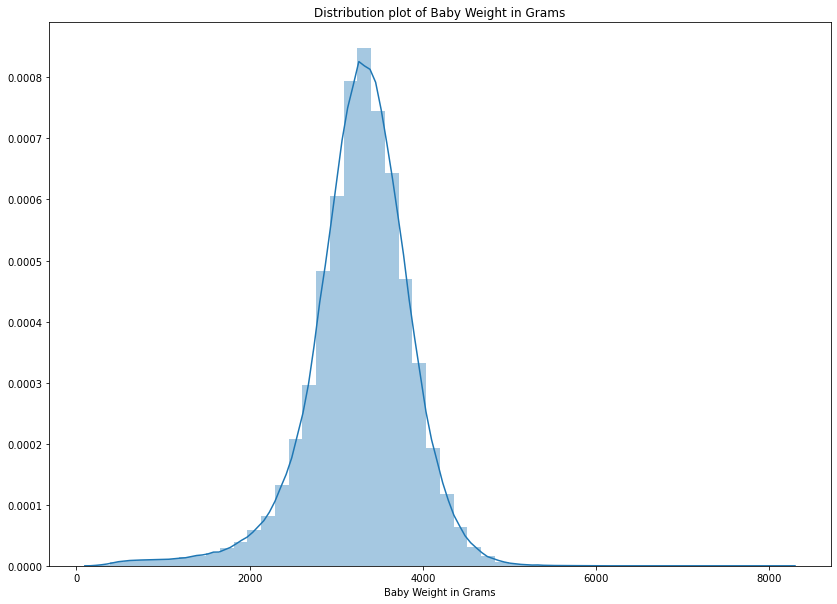

In [11]:
_X['DBWT'] = y
plt.figure(figsize=(14,10))
sns.distplot(_X['DBWT'])
plt.title('Distribution plot of Baby Weight in Grams')
plt.xlabel('Baby Weight in Grams');

### Two sample t test
null hypothesis: Male baby weight = Female baby weight<br>
alternative: Male body weight != Female baby weight

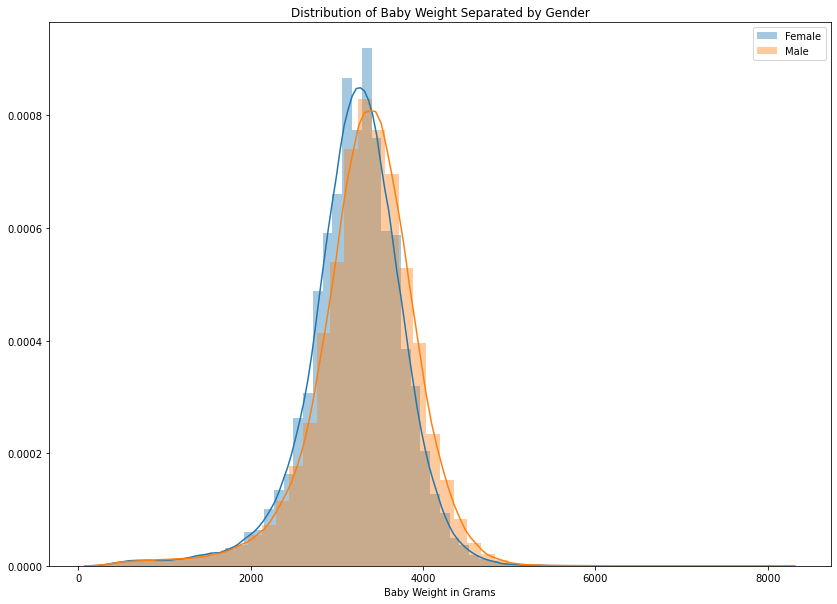

In [12]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['SEX_M'].eq(0)]['DBWT'], label = 'Female')
sns.distplot(_X[_X['SEX_M'].eq(1)]['DBWT'], label = 'Male')
plt.title('Distribution of Baby Weight Separated by Gender')
plt.xlabel('Baby Weight in Grams')
plt.legend();

In [13]:
# null: Male Baby Weight = Female Baby Weight
# alt: Male Baby Weight != Female Baby Weight
# alpha: 0.05
stats.f_oneway(_X[_X['SEX_M'].eq(0)]['DBWT'],
              _X[_X['SEX_M'].eq(1)]['DBWT'])
# reject null. There is significant evidence to suggest that male babies weigh differently than females.

F_onewayResult(statistic=2363.3496632216907, pvalue=0.0)

### Two sample t test
null hypothesis: Moms that never smoked[**baby weight**] = Moms that have smoked[**baby weight**]<br>
alternative: Moms that never smoked[**baby weight**] != Moms that have smoked[**baby weight**]

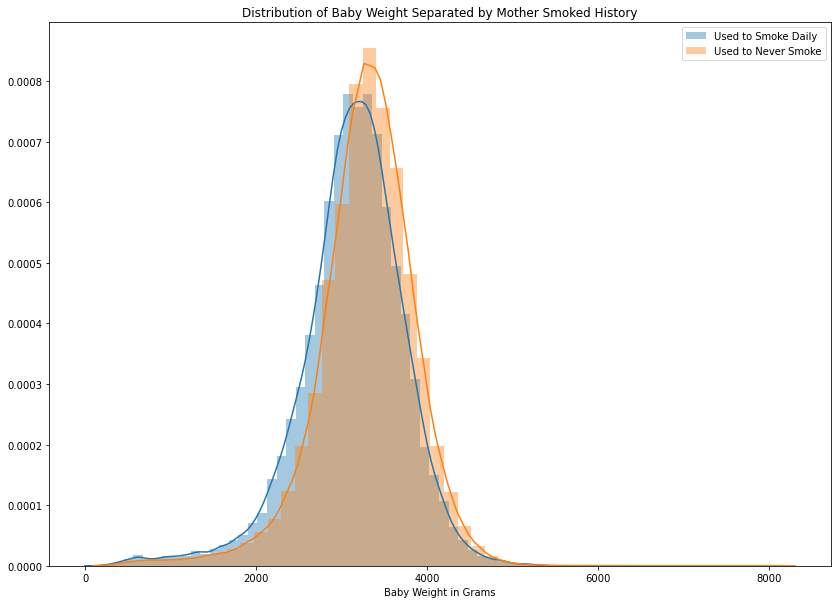

In [14]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['smoked_Daily'].eq(1)]['DBWT'], label = 'Used to Smoke Daily')
sns.distplot(_X[_X['smoked_None'].eq(1)]['DBWT'], label = 'Used to Never Smoke')
plt.title('Distribution of Baby Weight Separated by Mother Smoked History')
plt.xlabel('Baby Weight in Grams')
plt.legend();

In [15]:
# null: Baby Weight of Moms who used to Smoke Daily = Baby Weight of Moms who never smoked
# alt: Baby Weight of Moms who used to Smoke Daily != Baby Weight of Moms who never smoked
# alpha: 0.05
stats.f_oneway(_X[_X['smoked_Daily'].eq(1)]['DBWT'],
              _X[_X['smoked_None'].eq(1)]['DBWT'])
# reject null. There is significant evidence that moms who used to smoke have different baby weights than those who never smoked.

F_onewayResult(statistic=1293.7082003465355, pvalue=1.6167737389627832e-282)

### ANOVA test
null hypothesis: Baby weights of Moms of different races are equal <Br>
alternative: Baby weights of moms of different are NOT equal

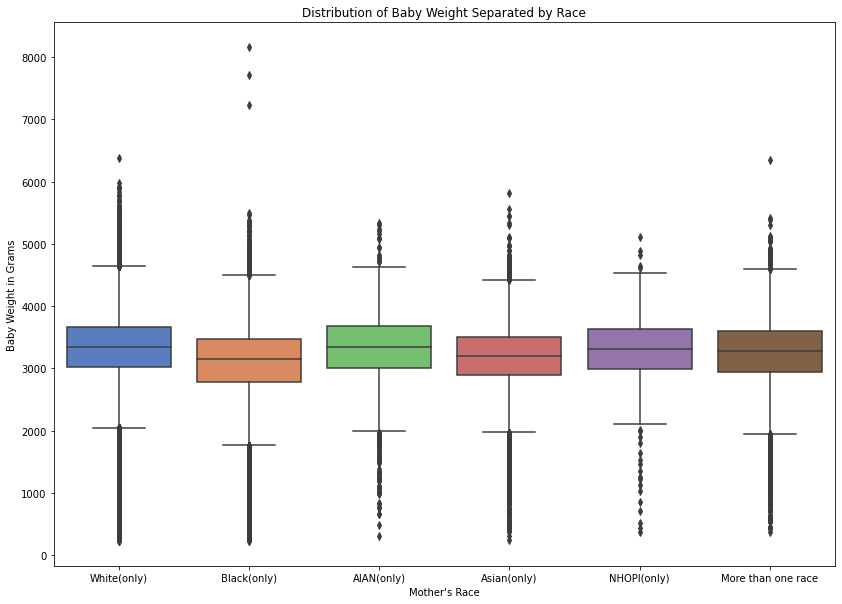

In [16]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='MRAVE6',y='DBWT', data=df, palette='muted')
ax.set_title('Distribution of Baby Weight Separated by Race')
ax.set_xlabel('Mother\'s Race')
ax.set_ylabel('Baby Weight in Grams')
ax.set_xticklabels(['White(only)','Black(only)','AIAN(only)','Asian(only)','NHOPI(only)','More than one race']);

In [17]:
# null: Baby Weights of Moms of different Race are equal
# alt: Baby Weights of Moms of different Race are NOT equal
# alpha: 0.05
stats.f_oneway(_X[_X['MRAVE6_1'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_2'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_3'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_4'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_5'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_6'].eq(1)]['DBWT'])
# reject null. There is significant evidence to suggest that the all race babies are not the same.

F_onewayResult(statistic=1053.8913312397567, pvalue=0.0)

##### POST-hoc using statsmodels tukeyhsd
Pairing all combinations of Race

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['MRAVE6'])
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-230.2393,0.001,-239.7533,-220.7254,True
1,3,-3.636,0.9,-38.701,31.429,False
1,4,-143.907,0.001,-157.5665,-130.2474,True
1,5,-29.4694,0.7252,-91.3576,32.4188,False
1,6,-82.6944,0.001,-104.0533,-61.3356,True
2,3,226.6033,0.001,190.7056,262.501,True
2,4,86.3324,0.001,70.6583,102.0064,True
2,5,200.7699,0.001,138.4061,263.1337,True
2,6,147.5449,0.001,124.8448,170.2449,True
3,4,-140.271,0.001,-177.4827,-103.0592,True


### ANOVA test
null hypothesis: Baby weights of all gestation periods are equal <br>
alternative: Baby weights of all gestations periods are NOT equal

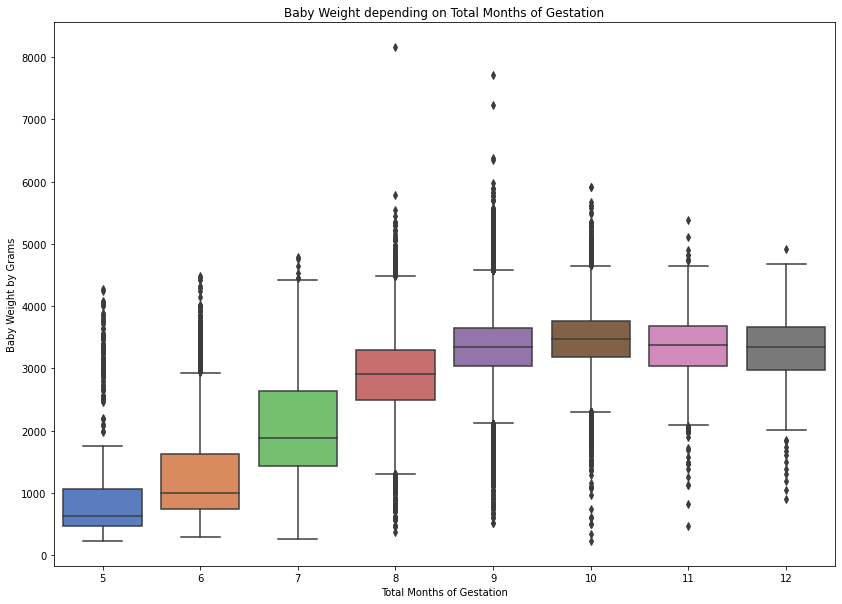

In [19]:
plt.figure(figsize=(14,10))
sns.boxplot(x='pregnancy_length',y='DBWT',data=df, palette = 'muted')
plt.title('Baby Weight depending on Total Months of Gestation')
plt.ylabel('Baby Weight by Grams')
plt.xlabel('Total Months of Gestation')
plt.savefig('Baby Weight Distribution separated by Gestation.png')

In [20]:
# null: Baby weights of all gestation periods are equal
# alt: Baby weights of all gestation periods are NOT equal
# alpha: 0.05
stats.f_oneway(df[df['pregnancy_length'].eq(5)]['DBWT'],
              df[df['pregnancy_length'].eq(6)]['DBWT'],
              df[df['pregnancy_length'].eq(7)]['DBWT'],
              df[df['pregnancy_length'].eq(8)]['DBWT'],
              df[df['pregnancy_length'].eq(9)]['DBWT'],
               df[df['pregnancy_length'].eq(10)]['DBWT'],
               df[df['pregnancy_length'].eq(11)]['DBWT'],
               df[df['pregnancy_length'].eq(12)]['DBWT'])
# reject null. There is significant evidence to suggest that that the length of gestation has an effect on baby weight

F_onewayResult(statistic=10666.27877474942, pvalue=0.0)

##### POST-hoc using statsmodels tukeyhsd
Pairing all combinations of Race

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['pregnancy_length'])
_result._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
5,6,243.4158,0.001,160.4317,326.3998,True
5,7,916.1025,0.001,841.3381,990.8669,True
5,8,1743.4005,0.001,1672.3673,1814.4336,True
5,9,2204.61,0.001,2134.0036,2275.2164,True
5,10,2336.2851,0.001,2265.2893,2407.2809,True
5,11,2211.1477,0.001,2129.9577,2292.3377,True
5,12,2155.607,0.001,2047.4502,2263.7639,True
6,7,672.6867,0.001,622.338,723.0354,True
6,8,1499.9847,0.001,1455.3642,1544.6051,True
6,9,1961.1942,0.001,1917.2563,2005.1321,True


# 3. Model Approach
A good amount of the time was spent feature selecting the variables that had a greater p-value score of 0.05. <br>
I first used all the columns from my dataframe and popped the columns that failed to reject the hypothesis that coefficients are not 0

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
_X_columns = _X.columns
_X[continuous_columns] = scaler.fit_transform(_X[continuous_columns])
_X = pd.DataFrame(data=_X, columns = _X_columns)

### Feature Selection
selecting columns that have lower than 0.05 p score from ols.summary()

In [23]:
_new_columns = [
#     'first_birth',
#  'first_pregnancy',
#  'first_natal',
 'MAGER',
#  'pregnancy_length',
#  'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
#  'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
#  'BMI',
 'ATTEND_1',
#  'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
#  'ATTEND_5',
#  'ATTEND_9',
#  'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
#  'BFACIL_4',
 'BFACIL_5',
#  'BFACIL_6',
#  'BFACIL_7',
#  'BFACIL_9',
#  'smoked_Daily',
 'smoked_None',
#  'smoked_Unknown',
#  'DOB_MM_1',
#  'DOB_MM_2',
#  'DOB_MM_3',
#  'DOB_MM_4',
#  'DOB_MM_5',
#  'DOB_MM_6',
#  'DOB_MM_7',
#  'DOB_MM_8',
#  'DOB_MM_9',
#  'DOB_MM_10',
#  'DOB_MM_11',
#  'DOB_MM_12',
#  'DMAR_0',
#  'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
#  'FHISPX_1',
#  'FHISPX_2',
#  'FHISPX_3',
#  'FHISPX_4',
#  'FHISPX_5',
#  'FHISPX_6',
#  'FHISPX_9',
#  'FEDUC_1',
#  'FEDUC_2',
#  'FEDUC_3',
#  'FEDUC_4',
#  'FEDUC_5',
 'FEDUC_6',
#  'FEDUC_7',
#  'FEDUC_8',
#  'FEDUC_9',
 'FRACE6_1',
#  'FRACE6_2',
#  'FRACE6_3',
 'FRACE6_4',
#  'FRACE6_5',
#  'FRACE6_6',
#  'FRACE6_9',
#  'plural_delivery_No',
 'plural_delivery_Yes',
#  'IP_GON_N',
#  'IP_GON_U',
#  'IP_GON_Y',
 'LD_INDL_N',
#  'LD_INDL_U',
#  'LD_INDL_Y',
#  'T35AGE_older_0',
 'T35AGE_older_1',
#  'MAR_IMP_1',
 'MBSTATE_REC_1',
#  'MBSTATE_REC_2',
#  'MBSTATE_REC_3',
 'MEDUC_1',
#  'MEDUC_2',
 'MEDUC_3',
 'MEDUC_4',
 'MEDUC_5',
 'MEDUC_6',
 'MEDUC_7',
#  'MEDUC_8',
#  'MEDUC_9',
 'MHISPX_0',
#  'MHISPX_1',
 'MHISPX_2',
#  'MHISPX_3',
#  'MHISPX_4',
#  'MHISPX_5',
 'MHISPX_6',
#  'MHISPX_9',
#  'MRAVE6_1',
 'MRAVE6_2',
#  'MRAVE6_3',
 'MRAVE6_4',
#  'MRAVE6_5',
 'MRAVE6_6',
#  'MTRAN_N',
#  'MTRAN_U',
 'MTRAN_Y',
 'NO_INFEC_0',
#  'NO_INFEC_1',
#  'NO_INFEC_9',
 'NO_MMORB_0',
#  'NO_MMORB_1',
#  'NO_MMORB_9',
 'NO_RISKS_0',
#  'NO_RISKS_1',
#  'NO_RISKS_9',
#  'PAY_1',
#  'PAY_2',
#  'PAY_3',
#  'PAY_4',
#  'PAY_5',
#  'PAY_6',
 'PAY_8',
#  'PAY_9',
 'PAY_REC_1',
#  'PAY_REC_2',
#  'PAY_REC_3',
#  'PAY_REC_4',
#  'PAY_REC_9',
#  'PRIORDEAD_cat_None',
#  'PRIORDEAD_cat_Unknown',
 'PRIORDEAD_cat_Yes',
#  'PRIORLIVE_cat_None',
#  'PRIORLIVE_cat_Unknown',
 'PRIORLIVE_cat_Yes',
#  'PRIORTERM_cat_None',
#  'PRIORTERM_cat_Unknown',
#  'PRIORTERM_cat_Yes',
#  'RDMETH_REC_1',
#  'RDMETH_REC_2',
 'RDMETH_REC_3',
#  'RDMETH_REC_4',
#  'RDMETH_REC_5',
#  'RDMETH_REC_6',
#  'RDMETH_REC_9',
 'RESTATUS_1',
#  'RESTATUS_2',
#  'RESTATUS_3',
#  'RESTATUS_4',
 'RF_CESAR_N',
#  'RF_CESAR_U',
#  'RF_CESAR_Y',
#  'SEX_F',
 'SEX_M',
#  'MAGER_cat_Adult',
 'MAGER_cat_Minor',
 'pregnancy_length_cat_10',
 'pregnancy_length_cat_8',
 'pregnancy_length_cat_9',
 'pregnancy_length_cat_Early',
#  'pregnancy_length_cat_Late',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'MRAVE6_1_FRACE6_1',
 'BFACIL_1_length',
 'BMI_log_length',
#  'M_Ht_In_length',
 'LD_INDL_N_length',
 'MTRAN_Y_length',
 'PRECARE_length',
 'PREVIS_length',
 'MOM_weight_length',
 'RDMETH_REC_3_pregnancy_length_cat_9',
 'RF_CESAR_Y_pregnancy_length_cat_9',
 'pregnancy_length_sqrt']

### Ordinary Least Squares

In [24]:

_X['DBWT'] = y
from statsmodels.formula.api import ols
formula = 'DBWT~'+'+'.join(_new_columns)
model = ols(formula=formula, data=_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1995.
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        22:09:12   Log-Likelihood:            -1.7424e+06
No. Observations:              230879   AIC:                         3.485e+06
Df Residuals:                  230808   BIC:                         3.486e+06
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            3148.4280     56.720     55.509      0.000    3037.259    3259.597
MAGER                                  -7.0720      1.640     -4.313      0.000     -10.286      -3.858
WTGAIN_div_length                      83.3052     11.260      7.398      0.000      61.236     105.374
PRECARE                               398.0051     11.889     33.477      0.000     374.703     421.307
PREVIS                                208.4139     12.259     17.001      0.000     184.387     232.441
BMI_log                               323.3623     30.040     10.764      0.000     264.485     382.240
M_Ht_In                               129.6275      2.862     45.289      0.000     124.018     135.237
MOM_weight                           -280.4987     29.849     -9.397      0.000    -339.001    -221.996
WTGAIN                                -62.4486     12.025     -5.193      0.000     -86.016     -38.881
WT_percent_gain                        88.5972      4.902     18.073      0.000      78.989      98.205
ATTEND_1                             -150.5172     34.842     -4.320      0.000    -218.806     -82.229
ATTEND_3                               53.6721      4.564     11.761      0.000      44.727      62.617
ATTEND_4                               69.6196     13.727      5.072      0.000      42.715      96.524
BFACIL_2                              145.7862     26.542      5.493      0.000      93.764     197.809
BFACIL_3                              188.9881     25.864      7.307      0.000     138.295     239.681
BFACIL_5                              125.7578     38.136      3.298      0.001      51.012     200.504
smoked_None                            46.9981     12.104      3.883      0.000      23.275      70.721
DMAR_2                                -15.8311      2.531     -6.256      0.000     -20.791     -10.871
FHISPX_0                               33.1531      2.840     11.675      0.000      27.587      38.719
FEDUC_6                                18.8167      2.835      6.636      0.000      13.259      24.374
FRACE6_1                               61.4122      6.597      9.309      0.000      48.482      74.342
FRACE6_4                              -74.6702      7.432    -10.047      0.000     -89.237     -60.104
plural_delivery_Yes                  -676.4330      8.778    -77.061      0.000    -693.638    -659.229
LD_INDL_N                            -205.5563     31.902     -6.443      0.000    -268.083    -143.030
T35AGE_older_1                         -7.6661      3.523     -2.176      0.030     -14.571      -0.761
MBSTATE_REC_1                         -54.5663      2.843    -19.194      0.000     -60.138     -48.994
MEDUC_1                                45.6245      6.257      7.29

In [25]:
_X

,first_birth,first_live_birth,first_natal,pregnancy_length_sqrt,MAGER,pregnancy_length,WTGAIN_div_MOM_weight,WTGAIN_div_length,PRECARE,PREVIS,PWgt_R,BMI_log,M_Ht_In,MOM_weight,WTGAIN,WT_percent_gain,BMI,ATTEND_1,ATTEND_2,ATTEND_3,ATTEND_4,ATTEND_5,ATTEND_9,BFACIL_1,BFACIL_2,BFACIL_3,BFACIL_4,BFACIL_5,BFACIL_6,BFACIL_7,BFACIL_9,smoked_Daily,smoked_None,smoked_Unknown,DOB_MM_1,DOB_MM_2,DOB_MM_3,DOB_MM_4,DOB_MM_5,DOB_MM_6,DOB_MM_7,DOB_MM_8,DOB_MM_9,DOB_MM_10,DOB_MM_11,DOB_MM_12,DMAR_0,DMAR_1,DMAR_2,FHISPX_0,FHISPX_1,FHISPX_2,FHISPX_3,FHISPX_4,FHISPX_5,FHISPX_6,FHISPX_9,FEDUC_1,FEDUC_2,FEDUC_3,FEDUC_4,FEDUC_5,FEDUC_6,FEDUC_7,FEDUC_8,FEDUC_9,FRACE6_1,FRACE6_2,FRACE6_3,FRACE6_4,FRACE6_5,FRACE6_6,FRACE6_9,plural_delivery_No,plural_delivery_Yes,IP_GON_N,IP_GON_U,IP_GON_Y,LD_INDL_N,LD_INDL_U,LD_INDL_Y,T35AGE_older_0,T35AGE_older_1,MAR_IMP_0,MAR_IMP_1,MBSTATE_REC_1,MBSTATE_REC_2,MBSTATE_REC_3,MEDUC_1,MEDUC_2,MEDUC_3,MEDUC_4,MEDUC_5,MEDUC_6,MEDUC_7,MEDUC_8,MEDUC_9,MHISPX_0,MHISPX_1,MHISPX_2,MHISPX_3,MHISPX_4,MHISPX_5,MHISPX_6,MHISPX_9,MRAVE6_1,MRAVE6_2,MRAVE6_3,MRAVE6_4,MRAVE6_5,MRAVE6_6,MTRAN_N,MTRAN_U,MTRAN_Y,NO_INFEC_0,NO_INFEC_1,NO_INFEC_9,NO_MMORB_0,NO_MMORB_1,NO_MMORB_9,NO_RISKS_0,NO_RISKS_1,NO_RISKS_9,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_8,PAY_9,PAY_REC_1,PAY_REC_2,PAY_REC_3,PAY_REC_4,PAY_REC_9,PRIORDEAD_cat_None,PRIORDEAD_cat_Unknown,PRIORDEAD_cat_Yes,PRIORLIVE_cat_None,PRIORLIVE_cat_Unknown,PRIORLIVE_cat_Yes,PRIORTERM_cat_None,PRIORTERM_cat_Unknown,PRIORTERM_cat_Yes,RDMETH_REC_1,RDMETH_REC_2,RDMETH_REC_3,RDMETH_REC_4,RDMETH_REC_5,RDMETH_REC_6,RDMETH_REC_9,RESTATUS_1,RESTATUS_2,RESTATUS_3,RESTATUS_4,RF_CESAR_N,RF_CESAR_U,RF_CESAR_Y,SEX_F,SEX_M,MAGER_cat_Adult,MAGER_cat_Minor,pregnancy_length_cat_10,pregnancy_length_cat_8,pregnancy_length_cat_9,pregnancy_length_cat_Early,pregnancy_length_cat_Late,MAGER_smoked_Daily,NO_RISKS_1_length,RDMETH_REC_3_length,RDMETH_REC_1_length,ATTEND_1_length,MRAVE6_1_FRACE6_1,BFACIL_1_length,BMI_log_length,M_Ht_In_length,LD_INDL_N_length,MTRAN_Y_length,PRECARE_length,PREVIS_length,MOM_weight_length,RDMETH_REC_3_pregnancy_length_cat_9,RF_CESAR_Y_pregnancy_length_cat_9,DBWT
0,0,0,1,0.061750,0.859586,0.043363,-0.349508,-0.307535,-0.559061,0.179679,-0.093311,-0.235093,0.662641,-0.095628,-0.299789,-0.350375,-0.317751,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,-0.290228,0.660832,-0.468403,0.703269,0.492332,1,0.134517,-0.128711,0.937923,0.625283,-0.066511,-0.548982,0.172604,-0.078732,0,0,3544
1,1,0,0,-1.412605,-0.696238,-1.425463,-1.401062,-1.277302,0.103197,0.412500,1.423291,1.513255,-0.044096,1.419874,-1.360242,-1.401232,1.532218,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,-0.290228,0.423769,-0.468403,0.470700,0.212472,1,-0.628687,-0.127550,0.716403,0.377502,-0.066511,-0.109849,0.072258,0.826730,0,0,2830
2,0,0,0,-1.412605,0.168109,-1.425463,-1.138049,-1.130615,-1.221319,-0.053141,-0.117384,0.287708,-0.750834,-0.112709,-1.227686,-1.137268,0.159661,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,-0.290228,-1.472730,-0.468403,-1.389851,0.212472,1,-0.628687,-0.880775,0.716403,0.377502,-0.066511,-1.280870,-0.329125,-0.495241,0,0,2381
3,0,0,1,-1.412605,1.378194,-1.425463,0.677582,0.409604,-0.559061,-0.285962,-1.056234,-0.991881,-0.750834,-1.059736,0.164

In [26]:
_X.drop(columns=['DBWT'],inplace=True)
_X.shape

(230879, 184)

In [27]:
_X[continuous_columns] = scaler.inverse_transform(_X[continuous_columns])


In [28]:
_X = _X.copy()
X_train, X_test, y_train, y_test = train_test_split(_X, y, random_state = 42, test_size=0.2)
scaler = StandardScaler()
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### Linear Regression
cross validating to see rmse, but more importantly looking to see if R2 improved

In [29]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_train_linreg = linreg.predict(X_train)
np.sqrt(metrics.mean_squared_error(y_train, y_train_linreg))

457.75708860250535

In [30]:
y_test_linreg = linreg.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_test_linreg))

459.63171396500076

In [31]:
linreg.score(X_test,y_test)

0.37320022432033806

### LassoCV
cross validating to see rmse, but more importantly looking to see if R2 improved

In [32]:
lasso_cv = LassoCV(cv=5, random_state=42, verbose=1)
lasso_cv.fit(X_train, y_train)
y_train_lasso = lasso_cv.predict(X_train)
np.sqrt(metrics.mean_squared_error(y_train, y_train_lasso))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.............................................................................................C:\Users\albert\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7223551.627620697, tolerance: 4983539.6193280155
  tol, rng, random, positive)
.C:\Users\albert\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7716057.638622284, tolerance: 4983539.6193280155
  tol, rng, random, positive)
.C:\Users\albert\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8119137.559230804, tolerance: 4983539.6193280

458.45947969310424

In [33]:
y_test_lasso = lasso_cv.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_test_lasso))

460.37404861037317

In [34]:
lasso_cv.score(X_test,y_test)

0.37117394582035457

# Key Insights